In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
from typing import Type
import torch
from torch import Tensor
import torch.optim as optim
import torch.nn as nn
from torch.nn import Flatten
import torchvision 
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
cwd = os.getcwd()
cwd

'/home/aarso2/BPI/Projeto_Semana6'

#### Criação do DataLoader de treino e validação

In [3]:
class DatasetEmotions(torch.utils.data.Dataset):
    def __init__(self,path, transforms = None):
        super().__init__()
        self.path = path
        self.images = glob.glob(os.path.join(self.path,"*_oneface/*"))
        self.labels = {"anger":0,"joy":1,"neutral":2}
        self.transforms = transforms
    def __getimages__(self):
        return self.images
    def __getitem__(self,idx):
        image = cv2.imread(self.images[idx])
        if self.transforms != None: 
            image = self.transforms(image)
        return image, self.labels[self.images[idx].split("/")[-2].replace("_oneface", "")]

    def __len__(self):
        return len(self.images)

In [4]:
# Define your data folder and optional image transformations
train_path = cwd+'/BPI-MELD-main/train/train_splits_images/'
dev_path = cwd+'/BPI-MELD-main/dev/dev_splits_images/'

transforming = T.Compose([T.ToPILImage(), T.Resize((112, 112)), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Create the custom dataset and data loader
train_dataset = DatasetEmotions(train_path, transforms=transforming)
dev_dataset = DatasetEmotions(dev_path, transforms=transforming)
train_data = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_data = DataLoader(dev_dataset, batch_size=32, shuffle=True)

In [5]:
#Get path images
path_name_dev = dev_dataset.__getimages__()
file_name_dev = []

for file in path_name_dev:
    file_name_dev.append(file.split("/")[-1].replace(".jpg", ""))

In [6]:
#Função auxiliar
def mode(group):
    mode_label = group.mode()
    if len(mode_label) == 1:
        return mode_label.iloc[0]
    else:
        return 999

In [7]:
total_samples_train = len(train_data) * train_data.batch_size
total_samples_dev = len(dev_data) * dev_data.batch_size
print(f"Total de amostras no conjunto de dados de treino: {total_samples_train}")
print(f"Total de amostras no conjunto de dados de teste: {total_samples_dev}")

Total de amostras no conjunto de dados de treino: 5760
Total de amostras no conjunto de dados de teste: 672


#### Convolutional Neural Network (CNN) baseline

In [7]:
# Define the neural network model
class EmotionRecognitionNet(nn.Module):
    def __init__(self, num_classes):
        super(EmotionRecognitionNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * (112 // 8) * (112 // 8), 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        x = self.fc_layers(x)
        return x

Epoch [1/10], Step [1/180], Loss: 1.0872
Epoch [1/10], Step [101/180], Loss: 1.0582
Validation Accuracy: 35.20%
Epoch [2/10], Step [1/180], Loss: 1.0852
Epoch [2/10], Step [101/180], Loss: 1.0740
Validation Accuracy: 35.36%
Epoch [3/10], Step [1/180], Loss: 1.1080
Epoch [3/10], Step [101/180], Loss: 1.0534
Validation Accuracy: 35.51%
Epoch [4/10], Step [1/180], Loss: 1.1392
Epoch [4/10], Step [101/180], Loss: 1.0003
Validation Accuracy: 35.05%
Epoch [5/10], Step [1/180], Loss: 1.0424
Epoch [5/10], Step [101/180], Loss: 0.9309
Validation Accuracy: 33.02%
Epoch [6/10], Step [1/180], Loss: 1.0601
Epoch [6/10], Step [101/180], Loss: 1.1512
Validation Accuracy: 34.58%
Epoch [7/10], Step [1/180], Loss: 1.1301
Epoch [7/10], Step [101/180], Loss: 1.0309
Validation Accuracy: 34.89%
Epoch [8/10], Step [1/180], Loss: 1.0157
Epoch [8/10], Step [101/180], Loss: 0.7637
Validation Accuracy: 34.11%
Epoch [9/10], Step [1/180], Loss: 0.7758
Epoch [9/10], Step [101/180], Loss: 0.7867
Validation Accuracy:

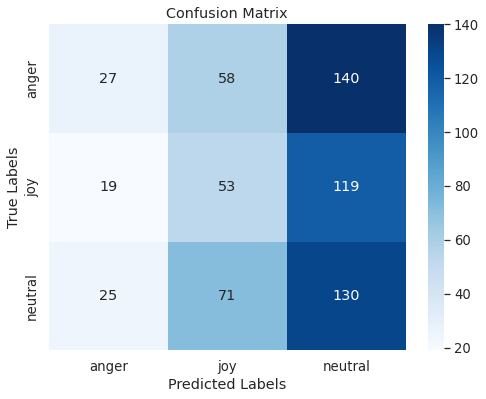

In [8]:

# Number of emotion classes
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = EmotionRecognitionNet(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (assuming you have train_data DataLoader)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_idx, (inputs, targets) in enumerate(train_data):
        # Move inputs and targets to the device (CPU or GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print training progress
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_data)}], Loss: {loss.item():.4f}')

    # Validation
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_predictions.extend(predicted.cpu().numpy().tolist())
            all_targets.extend(targets.cpu().numpy().tolist())

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

print('Training finished.')

# Calcula a accuracy final
accuracy = accuracy_score(all_targets, all_predictions)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
#Com isto conseguimos forçar que as labels estejam de acordo com a classe em que se encontram
df = pd.DataFrame({'images':file_name_dev,'label': all_predictions})

df['scene'] = df['images'].str[:-5]
scene_modes = df.groupby('scene')['label'].agg(mode).reset_index()
scene_modes.columns = ['scene', 'mode_label']

result_df = df.merge(scene_modes, on='scene', how='left')
result_df.drop(columns=['scene'], inplace=True)

result_df['mode_label'] = result_df.apply(lambda row: row['label'] if row['mode_label'] == 999 else row['mode_label'], axis=1)

new_labels = result_df['mode_label'].to_list()

Final Accuracy: 35.20%


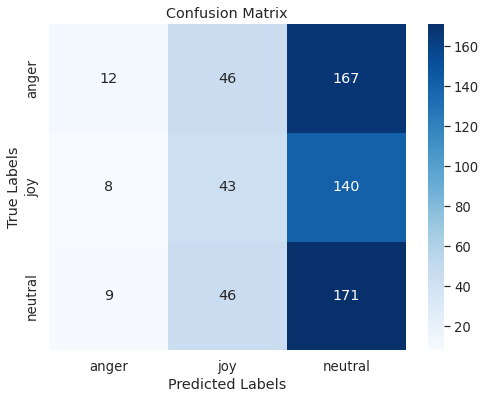

In [13]:
# Conseguimos concluir que o nosso processo aumenta a accuracy do modelo
accuracy = accuracy_score(all_targets, new_labels)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(all_targets, new_labels)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### AlexNet without pre-training

In [47]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # Modified input channels and kernel size
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Epoch [1/10], Step [1/180], Loss: 1.0979
Epoch [1/10], Step [101/180], Loss: 1.1101
Validation Accuracy: 35.20%
Epoch [2/10], Step [1/180], Loss: 1.0032
Epoch [2/10], Step [101/180], Loss: 1.0388
Validation Accuracy: 35.20%
Epoch [3/10], Step [1/180], Loss: 1.1353
Epoch [3/10], Step [101/180], Loss: 1.0616
Validation Accuracy: 35.20%
Epoch [4/10], Step [1/180], Loss: 1.0405
Epoch [4/10], Step [101/180], Loss: 1.0948
Validation Accuracy: 35.20%
Epoch [5/10], Step [1/180], Loss: 1.0255
Epoch [5/10], Step [101/180], Loss: 0.9570
Validation Accuracy: 35.20%
Epoch [6/10], Step [1/180], Loss: 1.0770
Epoch [6/10], Step [101/180], Loss: 1.0196
Validation Accuracy: 35.20%
Epoch [7/10], Step [1/180], Loss: 1.0233
Epoch [7/10], Step [101/180], Loss: 1.1478
Validation Accuracy: 35.20%
Epoch [8/10], Step [1/180], Loss: 1.0354
Epoch [8/10], Step [101/180], Loss: 1.0615
Validation Accuracy: 35.20%
Epoch [9/10], Step [1/180], Loss: 1.0126
Epoch [9/10], Step [101/180], Loss: 1.0782
Validation Accuracy:

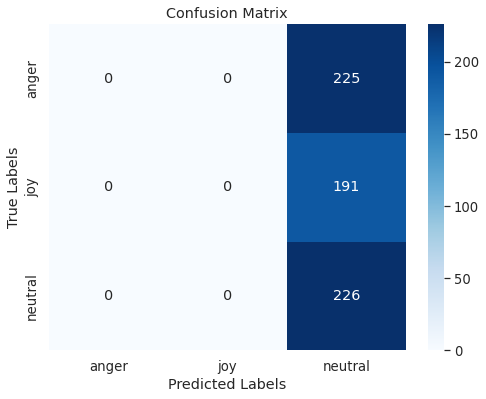

In [48]:
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alexnet_custom = AlexNet(num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet_custom.parameters(), lr=0.005, weight_decay = 0.005, momentum = 0.9) 

# Training loop (assuming you have train_data DataLoader)
num_epochs = 10

for epoch in range(num_epochs):
    alexnet_custom.train()  # Set the model to training mode
    for batch_idx, (inputs, targets) in enumerate(train_data):
        # Move inputs and targets to the device (CPU or GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = alexnet_custom(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print training progress
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_data)}], Loss: {loss.item():.4f}')

    # Validation
    alexnet_custom.eval()  # Set the model to evaluation mode
    alexnet_custom_predictions = []
    alexnet_custom_targets = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = alexnet_custom(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            alexnet_custom_predictions.extend(predicted.cpu().numpy().tolist())
            alexnet_custom_targets.extend(targets.cpu().numpy().tolist())

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

print('Training finished.')

# Calcula a accuracy final
accuracy = accuracy_score(alexnet_custom_targets, alexnet_custom_predictions)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(alexnet_custom_targets, alexnet_custom_predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### AlexNet network with pre-training

Epoch [1/10], Step [1/180], Loss: 1.1662
Epoch [1/10], Step [101/180], Loss: 1.0822
Validation Accuracy: 35.20%
Epoch [2/10], Step [1/180], Loss: 1.0242
Epoch [2/10], Step [101/180], Loss: 1.0650
Validation Accuracy: 35.20%
Epoch [3/10], Step [1/180], Loss: 1.0378
Epoch [3/10], Step [101/180], Loss: 1.0714
Validation Accuracy: 35.20%
Epoch [4/10], Step [1/180], Loss: 1.1077
Epoch [4/10], Step [101/180], Loss: 1.0556
Validation Accuracy: 35.20%
Epoch [5/10], Step [1/180], Loss: 1.0652
Epoch [5/10], Step [101/180], Loss: 1.0603
Validation Accuracy: 35.20%
Epoch [6/10], Step [1/180], Loss: 0.9655
Epoch [6/10], Step [101/180], Loss: 1.0630
Validation Accuracy: 35.20%
Epoch [7/10], Step [1/180], Loss: 1.0516
Epoch [7/10], Step [101/180], Loss: 1.1129
Validation Accuracy: 35.20%
Epoch [8/10], Step [1/180], Loss: 1.0742
Epoch [8/10], Step [101/180], Loss: 1.0929
Validation Accuracy: 35.20%
Epoch [9/10], Step [1/180], Loss: 1.0787
Epoch [9/10], Step [101/180], Loss: 1.0163
Validation Accuracy:

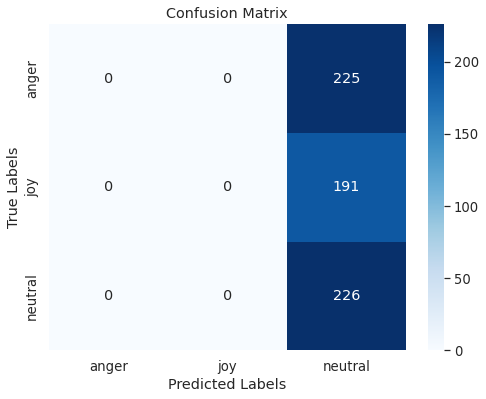

In [27]:
num_classes = 3

alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.001)

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

for epoch in range(num_epochs):
    alexnet.train()
    for batch_idx, (inputs, targets) in enumerate(train_data):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_data)}], Loss: {loss.item():.4f}')

    # Validation
    alexnet.eval()
    alexnet_predictions = []
    alexnet_targets = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = alexnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            alexnet_predictions.extend(predicted.cpu().numpy().tolist())
            alexnet_targets.extend(targets.cpu().numpy().tolist())

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

print('Training finished.')

# Calcula a accuracy final
accuracy = accuracy_score(alexnet_targets, alexnet_predictions)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(alexnet_targets, alexnet_predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### VGG16 Network without pre-training

In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Epoch [1/10], Step [1/180], Loss: 1.0951
Epoch [1/10], Step [101/180], Loss: 1.0479
Validation Accuracy: 35.20%
Epoch [2/10], Step [1/180], Loss: 1.0150
Epoch [2/10], Step [101/180], Loss: 1.1057
Validation Accuracy: 35.20%
Epoch [3/10], Step [1/180], Loss: 1.0866
Epoch [3/10], Step [101/180], Loss: 0.9868
Validation Accuracy: 35.20%
Epoch [4/10], Step [1/180], Loss: 1.0379
Epoch [4/10], Step [101/180], Loss: 1.0906
Validation Accuracy: 35.20%
Epoch [5/10], Step [1/180], Loss: 1.1443
Epoch [5/10], Step [101/180], Loss: 1.0676
Validation Accuracy: 35.20%
Epoch [6/10], Step [1/180], Loss: 1.0809
Epoch [6/10], Step [101/180], Loss: 1.0692
Validation Accuracy: 35.20%
Epoch [7/10], Step [1/180], Loss: 1.0880
Epoch [7/10], Step [101/180], Loss: 1.0958
Validation Accuracy: 35.20%
Epoch [8/10], Step [1/180], Loss: 1.0780
Epoch [8/10], Step [101/180], Loss: 1.0534
Validation Accuracy: 35.20%
Epoch [9/10], Step [1/180], Loss: 1.0135
Epoch [9/10], Step [101/180], Loss: 1.0864
Validation Accuracy:

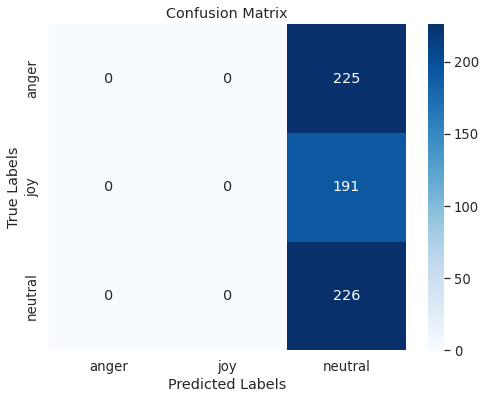

In [9]:
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vggnet16_custom = VGG16(num_classes=num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vggnet16_custom.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    vggnet16_custom.train()  # Set the model to training mode
    for batch_idx, (inputs, targets) in enumerate(train_data):
        # Move inputs and targets to the device (CPU or GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = vggnet16_custom(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print training progress
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_data)}], Loss: {loss.item():.4f}')

    # Validation
    vggnet16_custom.eval()  # Set the model to evaluation mode
    vggnet16_custom_predictions = []
    vggnet16_custom_targets = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = vggnet16_custom(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            vggnet16_custom_predictions.extend(predicted.cpu().numpy().tolist())
            vggnet16_custom_targets.extend(targets.cpu().numpy().tolist())

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

print('Training finished.')

# Calcula a accuracy final
accuracy = accuracy_score(vggnet16_custom_targets, vggnet16_custom_predictions)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(vggnet16_custom_targets, vggnet16_custom_predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### VGG16 Network with pre-training

Epoch [1/10], Step [1/180], Loss: 1.3260
Epoch [1/10], Step [101/180], Loss: 1.1276
Validation Accuracy: 32.24%
Epoch [2/10], Step [1/180], Loss: 1.1404
Epoch [2/10], Step [101/180], Loss: 1.2107
Validation Accuracy: 32.24%
Epoch [3/10], Step [1/180], Loss: 1.1326
Epoch [3/10], Step [101/180], Loss: 1.1902
Validation Accuracy: 32.24%
Epoch [4/10], Step [1/180], Loss: 1.2723
Epoch [4/10], Step [101/180], Loss: 1.2130
Validation Accuracy: 32.24%
Epoch [5/10], Step [1/180], Loss: 1.2171
Epoch [5/10], Step [101/180], Loss: 1.1753
Validation Accuracy: 32.24%
Epoch [6/10], Step [1/180], Loss: 1.1579
Epoch [6/10], Step [101/180], Loss: 1.1431
Validation Accuracy: 32.24%
Epoch [7/10], Step [1/180], Loss: 1.1960
Epoch [7/10], Step [101/180], Loss: 1.2844
Validation Accuracy: 32.24%
Epoch [8/10], Step [1/180], Loss: 1.0853
Epoch [8/10], Step [101/180], Loss: 1.2908
Validation Accuracy: 32.24%
Epoch [9/10], Step [1/180], Loss: 1.2399
Epoch [9/10], Step [101/180], Loss: 1.0865
Validation Accuracy:

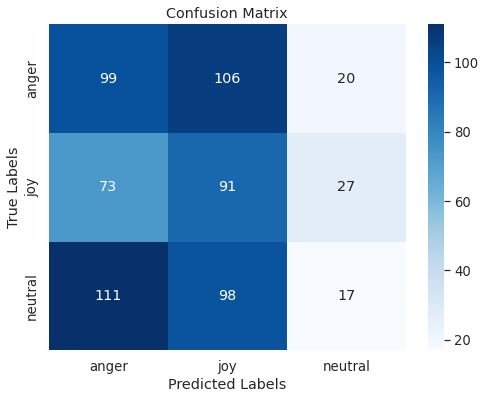

In [14]:
num_classes = 3

vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vggnet16_custom.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    for batch_idx, (inputs, targets) in enumerate(train_data):
        # Move inputs and targets to the device (CPU or GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = vgg16(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print training progress
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_data)}], Loss: {loss.item():.4f}')

    # Validation
    vgg16.eval()  # Set the model to evaluation mode
    vgg16_predictions = []
    vgg16_targets = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = vgg16(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            vgg16_predictions.extend(predicted.cpu().numpy().tolist())
            vgg16_targets.extend(targets.cpu().numpy().tolist())

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

print('Training finished.')

# Calcula a accuracy final
accuracy = accuracy_score(vgg16_targets, vgg16_predictions)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(vgg16_targets, vgg16_predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
#Com isto conseguimos forçar que as labels estejam de acordo com a classe em que se encontram
df = pd.DataFrame({'images':file_name_dev,'label': vgg16_predictions})

df['scene'] = df['images'].str[:-5]
scene_modes = df.groupby('scene')['label'].agg(mode).reset_index()
scene_modes.columns = ['scene', 'mode_label']

result_df = df.merge(scene_modes, on='scene', how='left')
result_df.drop(columns=['scene'], inplace=True)

result_df['mode_label'] = result_df.apply(lambda row: row['label'] if row['mode_label'] == 999 else row['mode_label'], axis=1)

new_labels = result_df['mode_label'].to_list()

Final Accuracy: 29.28%


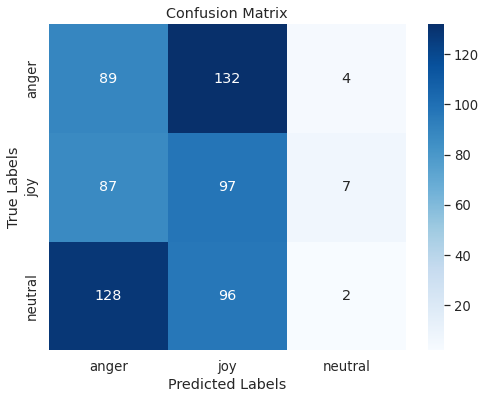

In [16]:
# Conseguimos concluir que o nosso processo faz variar a accuracy do modelo
accuracy = accuracy_score(vgg16_targets, new_labels)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(vgg16_targets, new_labels)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### ResNet-18 network without pre-training

In [24]:
class BasicBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return  out

# Define the ResNet-18 model

class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 3
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Example usage
resnet18_custom = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=3)

Epoch [1/10], Step [1/180], Loss: 1.1920
Epoch [1/10], Step [101/180], Loss: 1.1770
Validation Accuracy: 35.20%
Epoch [2/10], Step [1/180], Loss: 1.2013
Epoch [2/10], Step [101/180], Loss: 1.0289
Validation Accuracy: 36.14%
Epoch [3/10], Step [1/180], Loss: 1.1090
Epoch [3/10], Step [101/180], Loss: 1.1041
Validation Accuracy: 34.27%
Epoch [4/10], Step [1/180], Loss: 1.0852
Epoch [4/10], Step [101/180], Loss: 1.0393
Validation Accuracy: 38.63%
Epoch [5/10], Step [1/180], Loss: 1.0341
Epoch [5/10], Step [101/180], Loss: 1.1301
Validation Accuracy: 37.38%
Epoch [6/10], Step [1/180], Loss: 1.0723
Epoch [6/10], Step [101/180], Loss: 1.0553
Validation Accuracy: 36.76%
Epoch [7/10], Step [1/180], Loss: 0.9907
Epoch [7/10], Step [101/180], Loss: 1.0389
Validation Accuracy: 35.67%
Epoch [8/10], Step [1/180], Loss: 1.0423
Epoch [8/10], Step [101/180], Loss: 1.0307
Validation Accuracy: 35.83%
Epoch [9/10], Step [1/180], Loss: 0.9884
Epoch [9/10], Step [101/180], Loss: 1.1078
Validation Accuracy:

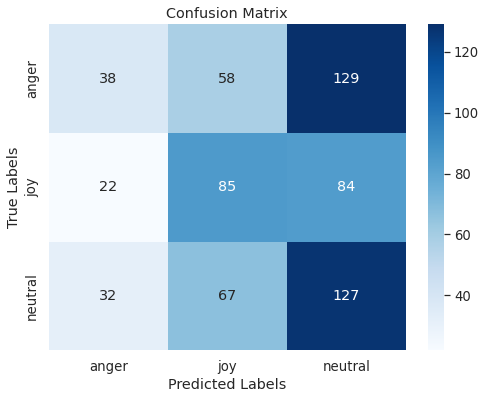

In [25]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_custom.parameters(), lr=0.001)

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_custom.to(device)

for epoch in range(num_epochs):
    resnet18_custom.train()
    for batch_idx, (inputs, targets) in enumerate(train_data):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = resnet18_custom(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_data)}], Loss: {loss.item():.4f}')

    # Validation
    resnet18_custom.eval()
    resnet_custom_predictions = []
    resnet_custom_targets = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = resnet18_custom(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            resnet_custom_predictions.extend(predicted.cpu().numpy().tolist())
            resnet_custom_targets.extend(targets.cpu().numpy().tolist())

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

print('Training finished.')

# Calcula a accuracy final
accuracy = accuracy_score(resnet_custom_targets, resnet_custom_predictions)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(resnet_custom_targets, resnet_custom_predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### ResNet-18 network with pre-training

Epoch [1/10], Step [1/180], Loss: 1.5010
Epoch [1/10], Step [101/180], Loss: 1.1633
Validation Accuracy: 34.42%
Epoch [2/10], Step [1/180], Loss: 0.9962
Epoch [2/10], Step [101/180], Loss: 1.0902
Validation Accuracy: 39.41%
Epoch [3/10], Step [1/180], Loss: 1.0059
Epoch [3/10], Step [101/180], Loss: 0.8875
Validation Accuracy: 35.20%
Epoch [4/10], Step [1/180], Loss: 0.8928
Epoch [4/10], Step [101/180], Loss: 1.0283
Validation Accuracy: 42.52%
Epoch [5/10], Step [1/180], Loss: 0.9151
Epoch [5/10], Step [101/180], Loss: 1.0011
Validation Accuracy: 36.45%
Epoch [6/10], Step [1/180], Loss: 0.8707
Epoch [6/10], Step [101/180], Loss: 0.8769
Validation Accuracy: 37.23%
Epoch [7/10], Step [1/180], Loss: 0.8001
Epoch [7/10], Step [101/180], Loss: 0.7272
Validation Accuracy: 37.07%
Epoch [8/10], Step [1/180], Loss: 0.5117
Epoch [8/10], Step [101/180], Loss: 0.7023
Validation Accuracy: 37.07%
Epoch [9/10], Step [1/180], Loss: 0.4387
Epoch [9/10], Step [101/180], Loss: 0.4867
Validation Accuracy:

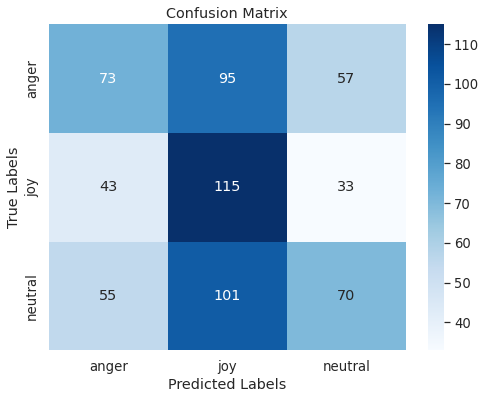

In [17]:
num_classes = 3

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

for epoch in range(num_epochs):
    resnet18.train()
    for batch_idx, (inputs, targets) in enumerate(train_data):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_data)}], Loss: {loss.item():.4f}')

    # Validation
    resnet18.eval()
    resnet_predictions = []
    resnet_targets = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = resnet18(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            resnet_predictions.extend(predicted.cpu().numpy().tolist())
            resnet_targets.extend(targets.cpu().numpy().tolist())

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

print('Training finished.')

# Calcula a accuracy final
accuracy = accuracy_score(resnet_targets, resnet_predictions)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(resnet_targets, resnet_predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
#Com isto conseguimos forçar que as labels estejam de acordo com a classe em que se encontram
df = pd.DataFrame({'images':file_name_dev,'label': resnet_predictions})

df['scene'] = df['images'].str[:-5]
scene_modes = df.groupby('scene')['label'].agg(mode).reset_index()
scene_modes.columns = ['scene', 'mode_label']

result_df = df.merge(scene_modes, on='scene', how='left')
result_df.drop(columns=['scene'], inplace=True)

result_df['mode_label'] = result_df.apply(lambda row: row['label'] if row['mode_label'] == 999 else row['mode_label'], axis=1)

new_labels = result_df['mode_label'].to_list()

Final Accuracy: 38.47%


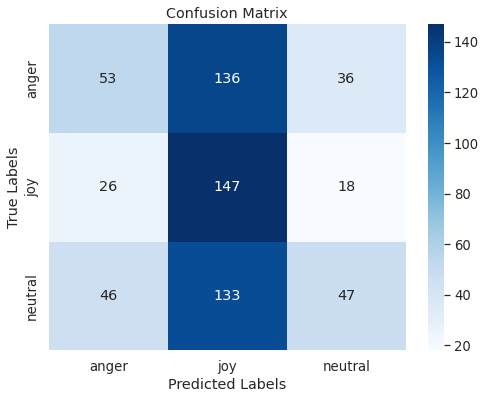

In [19]:
# Conseguimos concluir que o nosso processo faz variar a accuracy do modelo
accuracy = accuracy_score(resnet_targets, new_labels)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(resnet_targets, new_labels)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### ResNet-50 with pre-training

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/aarso2/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:07<00:00, 13.9MB/s]


Epoch [1/10], Step [1/180], Loss: 1.1082
Epoch [1/10], Step [101/180], Loss: 1.0714
Validation Accuracy: 36.14%
Epoch [2/10], Step [1/180], Loss: 1.1242
Epoch [2/10], Step [101/180], Loss: 1.0152
Validation Accuracy: 36.92%
Epoch [3/10], Step [1/180], Loss: 1.1552
Epoch [3/10], Step [101/180], Loss: 1.0371
Validation Accuracy: 35.67%
Epoch [4/10], Step [1/180], Loss: 1.0720
Epoch [4/10], Step [101/180], Loss: 0.9973
Validation Accuracy: 35.36%
Epoch [5/10], Step [1/180], Loss: 1.0637
Epoch [5/10], Step [101/180], Loss: 1.1146
Validation Accuracy: 37.38%
Epoch [6/10], Step [1/180], Loss: 0.9248
Epoch [6/10], Step [101/180], Loss: 1.1232
Validation Accuracy: 40.50%
Epoch [7/10], Step [1/180], Loss: 1.0066
Epoch [7/10], Step [101/180], Loss: 1.1188
Validation Accuracy: 35.83%
Epoch [8/10], Step [1/180], Loss: 1.0046
Epoch [8/10], Step [101/180], Loss: 1.0773
Validation Accuracy: 41.28%
Epoch [9/10], Step [1/180], Loss: 0.8088
Epoch [9/10], Step [101/180], Loss: 0.8473
Validation Accuracy:

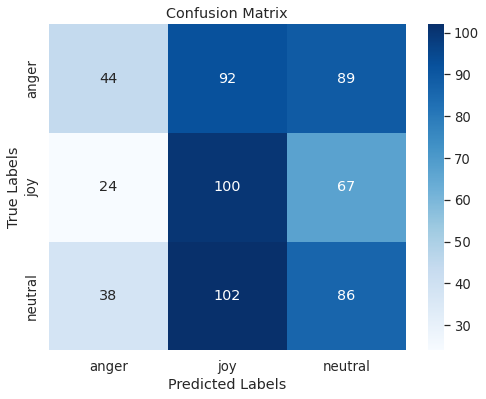

In [23]:
num_classes = 3

resnet18 = models.resnet50(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

for epoch in range(num_epochs):
    resnet18.train()
    for batch_idx, (inputs, targets) in enumerate(train_data):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_data)}], Loss: {loss.item():.4f}')

    # Validation
    resnet18.eval()
    resnet_predictions = []
    resnet_targets = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = resnet18(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            resnet_predictions.extend(predicted.cpu().numpy().tolist())
            resnet_targets.extend(targets.cpu().numpy().tolist())

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

print('Training finished.')

# Calcula a accuracy final
accuracy = accuracy_score(resnet_targets, resnet_predictions)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(resnet_targets, resnet_predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Hyperparameter Tuning

In [30]:
class DatasetEmotionsBest(torch.utils.data.Dataset):
    def __init__(self,path, transforms = None):
        super().__init__()
        self.path = path
        self.images = glob.glob(os.path.join(self.path,"*_oneface/*"))
        self.labels = {"anger":0,"joy":1,"neutral":2}
        self.transforms = transforms
    def __getimages__(self):
        return self.images
    def __getitem__(self,idx):
        image = cv2.imread(self.images[idx])
        if self.transforms != None: 
            image = self.transforms(image)
        return image, self.labels[self.images[idx].split("/")[-2].replace("_oneface", "")]

    def __len__(self):
        return len(self.images)

In [31]:
# Define your data folder and optional image transformations
train_path = cwd+'/BPI-MELD-main/train/train_splits_images/'
dev_path = cwd+'/BPI-MELD-main/dev/dev_splits_images/'

transforming = T.Compose([T.ToPILImage(), T.Resize((150, 150)), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Create the custom dataset and data loader
train_dataset_best = DatasetEmotionsBest(train_path, transforms=transforming)
dev_dataset_best = DatasetEmotionsBest(dev_path, transforms=transforming)
train_data_best = DataLoader(train_dataset_best, batch_size=32, shuffle=True)
dev_data_best = DataLoader(dev_dataset_best, batch_size=32, shuffle=True)

In [32]:
#Get path images
path_name_dev = dev_dataset_best.__getimages__()
file_name_dev = []

for file in path_name_dev:
    file_name_dev.append(file.split("/")[-1].replace(".jpg", ""))

Epoch [1/10], Step [1/180], Loss: 1.2540
Epoch [1/10], Step [101/180], Loss: 1.2167
Validation Accuracy: 36.14%
Epoch [2/10], Step [1/180], Loss: 0.9833
Epoch [2/10], Step [101/180], Loss: 1.1336
Validation Accuracy: 39.41%
Epoch [3/10], Step [1/180], Loss: 1.0291
Epoch [3/10], Step [101/180], Loss: 1.0318
Validation Accuracy: 34.89%
Epoch [4/10], Step [1/180], Loss: 0.8561
Epoch [4/10], Step [101/180], Loss: 0.9683
Validation Accuracy: 39.10%
Epoch [5/10], Step [1/180], Loss: 0.9989
Epoch [5/10], Step [101/180], Loss: 0.9654
Validation Accuracy: 36.92%
Epoch [6/10], Step [1/180], Loss: 0.8037
Epoch [6/10], Step [101/180], Loss: 0.8292
Validation Accuracy: 36.14%
Epoch [7/10], Step [1/180], Loss: 0.6797
Epoch [7/10], Step [101/180], Loss: 0.7266
Validation Accuracy: 36.45%
Epoch [8/10], Step [1/180], Loss: 0.7004
Epoch [8/10], Step [101/180], Loss: 0.6622
Validation Accuracy: 33.49%
Epoch [9/10], Step [1/180], Loss: 0.4957
Epoch [9/10], Step [101/180], Loss: 0.2925
Validation Accuracy:

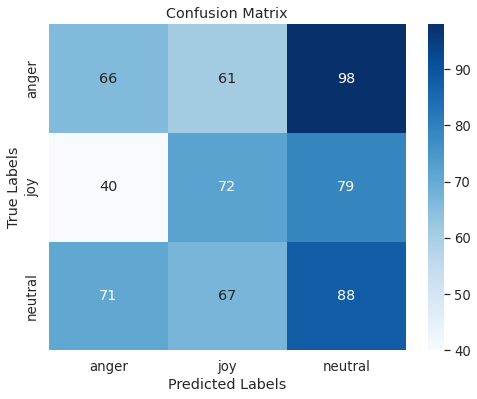

In [29]:
num_classes = 3

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

for epoch in range(num_epochs):
    resnet18.train()
    for batch_idx, (inputs, targets) in enumerate(train_data_best):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_data_best)}], Loss: {loss.item():.4f}')

    # Validation
    resnet18.eval()
    resnet_predictions = []
    resnet_targets = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_data_best:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = resnet18(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            resnet_predictions.extend(predicted.cpu().numpy().tolist())
            resnet_targets.extend(targets.cpu().numpy().tolist())

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

print('Training finished.')

# Calcula a accuracy final
accuracy = accuracy_score(resnet_targets, resnet_predictions)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(resnet_targets, resnet_predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()